In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
import glob
import os
from tqdm import tqdm

In [30]:
folders = glob.glob("/home/long/Train/*")

label_map = ['astilbe',
             'black-eyed susan',
             'bellflower',
             'tulip',
             'california poppy',
             'calendula']

In [6]:
print("[INFO] loading images...")

data = []
labels = []

# for mask img
# loop over the image paths
for folder in tqdm(folders):
    images = glob.glob(folder + "/*")
    for imagePath in images:
        # extract the class label from the filename
        label = label_map.index(folder.split("/")[-1])

        # load the input image (224x224) and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)



# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


In [7]:
# perform one-hot encoding on the labels
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42)

In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

2022-05-11 22:10:53.352320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 22:10:53.352665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 22:10:53.352698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-11 22:10:53.352727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-11 22:10:53.352756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [12]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/home/long/miniconda3/envs/duc/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 1.4329 - accuracy: 0.4590

2022-05-11 22:11:33.727291: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 626196480 exceeds 10% of free system memory.


129/129 [==============================] - 47s 352ms/step - loss: 1.4329 - accuracy: 0.4590 - val_loss: 0.7597 - val_accuracy: 0.8385
Epoch 2/20
129/129 [==============================] - 45s 350ms/step - loss: 0.7781 - accuracy: 0.7315 - val_loss: 0.4669 - val_accuracy: 0.8875
Epoch 3/20
129/129 [==============================] - 45s 346ms/step - loss: 0.5741 - accuracy: 0.8095 - val_loss: 0.3649 - val_accuracy: 0.9067
Epoch 4/20
129/129 [==============================] - 45s 348ms/step - loss: 0.4796 - accuracy: 0.8371 - val_loss: 0.3204 - val_accuracy: 0.9125
Epoch 5/20
129/129 [==============================] - 44s 343ms/step - loss: 0.4279 - accuracy: 0.8500 - val_loss: 0.2874 - val_accuracy: 0.9231
Epoch 6/20
129/129 [==============================] - 45s 346ms/step - loss: 0.3930 - accuracy: 0.8706 - val_loss: 0.2764 - val_accuracy: 0.9154
Epoch 7/20
129/129 [==============================] - 45s 345ms/step - loss: 0.3543 - accuracy: 0.8776 - val_loss: 0.2638 - val_accuracy: 0.9

In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


2022-05-11 22:26:07.742737: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 626196480 exceeds 10% of free system memory.


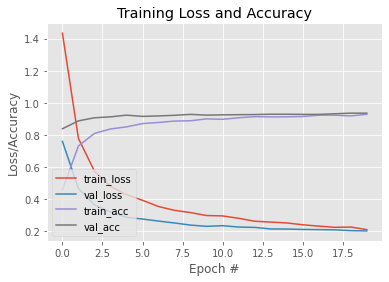

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])

In [17]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=label_map))

                  precision    recall  f1-score   support

         astilbe       0.95      0.91      0.93       149
black-eyed susan       0.98      0.99      0.99       194
      bellflower       0.89      0.94      0.92       155
           tulip       0.96      0.98      0.97       185
california poppy       0.88      0.92      0.90       163
       calendula       0.94      0.87      0.90       194

        accuracy                           0.94      1040
       macro avg       0.93      0.93      0.93      1040
    weighted avg       0.94      0.94      0.94      1040



In [22]:
import pretty_confusion_matrix

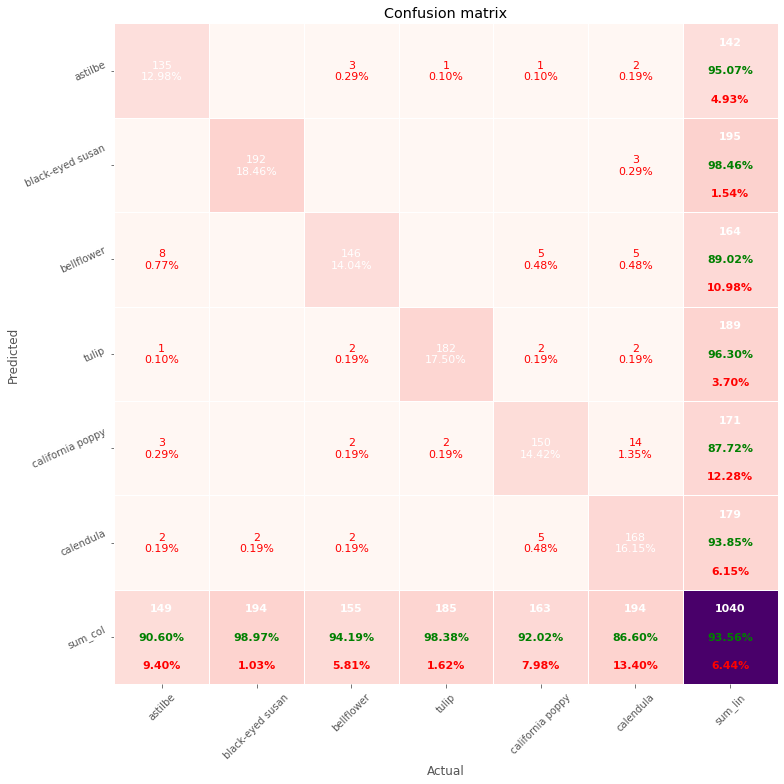

In [29]:
import numpy as np
import pandas as pd
from pretty_confusion_matrix import pp_matrix

conf = confusion_matrix(testY.argmax(axis=1), predIdxs)

# get pandas dataframe
df_cm = pd.DataFrame(conf, index=label_map, columns=label_map)
# colormap: see this and choose your more dear
cmap = 'RdPu'
pp_matrix(df_cm, cmap=cmap, figsize=(11, 11))